# 

In [1]:
!pip install torchio --quiet
!pip install monai --quiet
!pip install ipywidgets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.8 MB/s eta 0:00:0000:010:01


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchio as tio
import itertools
import imageio
import torchmetrics
import plotly.graph_objects as go
from torch.utils.data import Dataset, DataLoader
from glob import glob
from torchmetrics.segmentation import DiceScore
from torch.optim.lr_scheduler import StepLR
from monai.networks.nets import AttentionUnet
from torchio import transforms
from ipywidgets import interact, IntSlider
from IPython.display import FileLink


num_workers = os.cpu_count()//2
print(num_workers)

2


here, I made file paths for each subject for FLAIR, T1, T1ce, T2, and segmentation files,
to make my dataset

In [3]:
base_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
subject_dirs = sorted(glob(os.path.join(base_dir, "BraTS20_Training_*")))
subject_paths = []

for subject_dir in subject_dirs:
    subject_id = os.path.basename(subject_dir)  

    flair = os.path.join(subject_dir, f"{subject_id}_flair.nii")
    t1 = os.path.join(subject_dir, f"{subject_id}_t1.nii")
    t1ce = os.path.join(subject_dir, f"{subject_id}_t1ce.nii")
    t2 = os.path.join(subject_dir, f"{subject_id}_t2.nii")
    seg = os.path.join(subject_dir, f"{subject_id}_seg.nii")

    subject_paths.append({
        "flair": flair,
        "t1": t1,
        "t1ce": t1ce,
        "t2": t2,
        "seg": seg
    })

here, I made a a tio.Subject having FLAIR, T1, T1ce, and T2 images and segmentation files.

In [4]:
subjects = []

for paths in subject_paths:
    if not all(os.path.exists(paths[key]) for key in paths):
        continue  
    subject = tio.Subject(
        flair=tio.ScalarImage(paths["flair"]),
        t1=tio.ScalarImage(paths["t1"]),
        t1ce=tio.ScalarImage(paths["t1ce"]),
        t2=tio.ScalarImage(paths["t2"]),
        seg=tio.LabelMap(paths["seg"])
    )
    subjects.append(subject)



I splitted the training dataset to test and validation,
since validation dataset of Brats2020 does not have segmentation files.

In [5]:
split_index = int(len(subjects)* 0.8)
training_subjects = subjects[:split_index]
validation_subjects = subjects[split_index:]

here, I apply transforms(for example I cropped 3D images to have minimal background area, 
also I wanted the shape to be appropriate for the model. since we have 4 downsamplings(max pools) and i wanted to avoid shape errors realted to alignment to skip-connections). For augmentations, I tried to choose most relevent transforms from torchio to have a near real-world variability in MRI scans.

In [6]:
my_transforms = tio.transforms.Compose([
    tio.ToCanonical(),
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.Crop([45,45,17,35,13,24]),
    tio.Resample(1.5),
    tio.EnsureShapeMultiple(2**4),
    tio.SequentialLabels(),     
    
])

my_augmentation = tio.OneOf([
    tio.RandomGhosting(intensity=0.5),
    tio.RandomSpike(intensity=1.0),
    tio.RandomBiasField(coefficients=0.5),
    tio.RandomMotion(degrees=10, translation=10),
    tio.RandomElasticDeformation()
], p=0.70)


final_transform = tio.Compose([
    my_transforms,
    my_augmentation,
])

For each batch, I concatenated  (T1, T2, T1ce, and FLAIR) along 
the channel dimension to form a multi-channel image. 
The segmentation labels are stacked separately.

In [7]:
def collate(batch):
    concated_images = torch.stack([
        torch.cat([subject.t1.data, subject.t2.data, subject.t1ce.data, subject.flair.data], dim=0) 
        for subject in batch
    ], dim=0)
    
    seperated_labels = torch.stack([subject.seg.data for subject in batch], dim=0)
    
    return concated_images, seperated_labels

here, I made datasets and dataloaders with batch size of 8 and I applied my collate function.

In [8]:
train_dataset = tio.SubjectsDataset(training_subjects,transform= final_transform)
validation_dataset = tio.SubjectsDataset(validation_subjects,transform= final_transform)
dataloader = tio.SubjectsLoader(train_dataset, batch_size=8, collate_fn = collate)
validation_dataloader = tio.SubjectsLoader(validation_dataset, batch_size=8, collate_fn = collate)

here, I defined the dice loss class for 5 dimentions that returns 1- dice score.

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predict, target):
     
        if predict.ndimension() != 5 or target.ndimension() != 5:
            raise ValueError(f"Expected predict & target to have 5 dimensions (N, C, D, H, W), but got {predict.shape} and {target.shape}")

        N, C, D, H, W = predict.shape

        predict = F.softmax(predict, dim=1) 

        predict = predict.view(N, C, -1)
        target = target.view(N, C, -1)

        intersection = torch.sum(predict * target, dim=2)
        union = torch.sum(predict, dim=2) + torch.sum(target, dim=2)

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)

        dice_loss = 1 - dice_score.mean()

        return dice_loss

here, I decided to use attentionunet after 
trying unet itself with different learning rates and lr schedulers. The unet did not learn to an acceptable rate.
Also, I tried attenunet with 3 downsamplings which was not capable to learn properly.

In [10]:
model = AttentionUnet(
    spatial_dims=3,
    in_channels=4,  
    out_channels=4,  
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),

)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
model = nn.DataParallel(model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
loss_fn = DiceLoss()

A function to evaluate model

In [11]:
def evaluate_model(model, dataloader, device, loss_fn):
    model.eval()  
    total_loss = 0.0

    with torch.no_grad():  
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)

           
            masks = F.one_hot(masks.long(), num_classes=4)  
            masks = masks.squeeze(1)  
            masks = masks.permute(0, 4, 1, 2, 3).float()

            segmentation_mask = model(images)
            loss = loss_fn(segmentation_mask, masks)  
            total_loss += loss.item()

    mean_loss = total_loss / len(dataloader)
    print(f"Mean Segmentation Loss (Dice): {mean_loss:.4f}")

    return mean_loss

I trained seperatly for 20,3,3 and 2 epochs respectively to have my training details in my notebook.

In [14]:
'''training for first 20 epochs'''
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    running_seg_loss = 0.0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        if masks.shape[1] == 1:  
            masks = masks.squeeze(1) 

        masks = F.one_hot(masks.long(), num_classes=4) 
        masks = masks.permute(0, 4, 1, 2, 3)  
        masks = masks.float()  

       
        segmentation_mask = model(images) 
        total_loss = loss_fn(segmentation_mask, masks)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_seg_loss += total_loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}],  Loss: {running_seg_loss / len(dataloader):.4f}")


100%|██████████| 37/37 [14:19<00:00, 23.23s/it]


Epoch [1/20],  Loss: 0.7212


100%|██████████| 37/37 [13:28<00:00, 21.85s/it]


Epoch [2/20],  Loss: 0.6083


100%|██████████| 37/37 [12:20<00:00, 20.01s/it]


Epoch [3/20],  Loss: 0.5141


100%|██████████| 37/37 [11:44<00:00, 19.05s/it]


Epoch [4/20],  Loss: 0.4488


100%|██████████| 37/37 [12:21<00:00, 20.05s/it]


Epoch [5/20],  Loss: 0.4348


100%|██████████| 37/37 [14:04<00:00, 22.82s/it]


Epoch [6/20],  Loss: 0.4176


100%|██████████| 37/37 [13:30<00:00, 21.90s/it]


Epoch [7/20],  Loss: 0.3897


100%|██████████| 37/37 [13:58<00:00, 22.65s/it]


Epoch [8/20],  Loss: 0.3874


100%|██████████| 37/37 [13:58<00:00, 22.66s/it]


Epoch [9/20],  Loss: 0.3923


100%|██████████| 37/37 [14:58<00:00, 24.28s/it]


Epoch [10/20],  Loss: 0.3832


100%|██████████| 37/37 [15:03<00:00, 24.41s/it]


Epoch [11/20],  Loss: 0.3836


100%|██████████| 37/37 [14:46<00:00, 23.96s/it]


Epoch [12/20],  Loss: 0.3655


100%|██████████| 37/37 [14:47<00:00, 23.98s/it]


Epoch [13/20],  Loss: 0.3560


100%|██████████| 37/37 [14:21<00:00, 23.28s/it]


Epoch [14/20],  Loss: 0.3622


100%|██████████| 37/37 [14:40<00:00, 23.79s/it]


Epoch [15/20],  Loss: 0.3573


100%|██████████| 37/37 [13:28<00:00, 21.84s/it]


Epoch [16/20],  Loss: 0.3457


100%|██████████| 37/37 [14:28<00:00, 23.46s/it]


Epoch [17/20],  Loss: 0.3653


100%|██████████| 37/37 [15:02<00:00, 24.39s/it]


Epoch [18/20],  Loss: 0.3437


100%|██████████| 37/37 [15:39<00:00, 25.40s/it]


Epoch [19/20],  Loss: 0.3325


100%|██████████| 37/37 [14:00<00:00, 22.72s/it]

Epoch [20/20],  Loss: 0.3287


In [17]:
'''3 more epochs'''
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    running_seg_loss = 0.0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        if masks.shape[1] == 1:  
            masks = masks.squeeze(1) 

        masks = F.one_hot(masks.long(), num_classes=4) 
        masks = masks.permute(0, 4, 1, 2, 3)  
        masks = masks.float()  

       
        segmentation_mask = model(images) 
        total_loss = loss_fn(segmentation_mask, masks)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_seg_loss += total_loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}],  Loss: {running_seg_loss / len(dataloader):.4f}")


100%|██████████| 37/37 [11:28<00:00, 18.60s/it]


Epoch [1/3],  Loss: 0.3204


100%|██████████| 37/37 [12:25<00:00, 20.16s/it]


Epoch [2/3],  Loss: 0.3269


100%|██████████| 37/37 [13:27<00:00, 21.83s/it]

Epoch [3/3],  Loss: 0.3161


In [19]:
'''3 more epochs'''
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    running_seg_loss = 0.0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        if masks.shape[1] == 1:  
            masks = masks.squeeze(1) 

        masks = F.one_hot(masks.long(), num_classes=4) 
        masks = masks.permute(0, 4, 1, 2, 3)  
        masks = masks.float()  

       
        segmentation_mask = model(images) 
        total_loss = loss_fn(segmentation_mask, masks)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_seg_loss += total_loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}],  Loss: {running_seg_loss / len(dataloader):.4f}")


100%|██████████| 37/37 [14:13<00:00, 23.06s/it]


Epoch [1/3],  Loss: 0.3077


100%|██████████| 37/37 [14:10<00:00, 22.99s/it]


Epoch [2/3],  Loss: 0.3142


100%|██████████| 37/37 [12:28<00:00, 20.23s/it]

Epoch [3/3],  Loss: 0.3092


In [21]:
'''last 2 epochs'''
EPOCHS = 2
for epoch in range(EPOCHS):
    model.train()
    running_seg_loss = 0.0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        if masks.shape[1] == 1:  
            masks = masks.squeeze(1) 

        masks = F.one_hot(masks.long(), num_classes=4) 
        masks = masks.permute(0, 4, 1, 2, 3)  
        masks = masks.float()  

       
        segmentation_mask = model(images) 
        total_loss = loss_fn(segmentation_mask, masks)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_seg_loss += total_loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}],  Loss: {running_seg_loss / len(dataloader):.4f}")


100%|██████████| 37/37 [14:35<00:00, 23.66s/it]


Epoch [1/2],  Loss: 0.3040


100%|██████████| 37/37 [12:04<00:00, 19.58s/it]

Epoch [2/2],  Loss: 0.3028


In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

torch.save(model.module.state_dict(), "lastbrats+8.pth")

download_file("lastbrats+8.pth", "lastbrats+8.pth")

In [26]:
'''I evaluated model using my own dice loss'''
evaluate_model(model, validation_dataloader, device, loss_fn)

Evaluating: 100%|██████████| 10/10 [03:44<00:00, 22.47s/it]

Mean Segmentation Loss (Dice): 0.4035


0.40346508026123046

I also decided to try built-in DiceScore in torchmetrics as well

In [27]:
dice_score = DiceScore(num_classes=4, average="weighted", include_background=False).to(device)
model.eval()
model.to(device)

with torch.no_grad():
    for x, y in tqdm(validation_dataloader):
        logits = model(x.to(device))
        label = nn.functional.one_hot(
            y.long(),
            num_classes=4).squeeze(1)
        label = label.permute(0, 4, 1, 2, 3).bool()
        pred = nn.functional.one_hot(
                logits.argmax(dim=1),
                num_classes=4)
        pred = pred.permute(0, 4, 1, 2, 3).bool()
        dice = dice_score(pred, label.to(device))
        print(dice)

 10%|█         | 1/10 [00:19<02:55, 19.51s/it]

tensor(0.5553, device='cuda:0')


 20%|██        | 2/10 [00:34<02:12, 16.61s/it]

tensor(0.5727, device='cuda:0')


 30%|███       | 3/10 [00:55<02:12, 18.89s/it]

tensor(0.4535, device='cuda:0')


 40%|████      | 4/10 [01:12<01:48, 18.05s/it]

tensor(0.4257, device='cuda:0')


 50%|█████     | 5/10 [01:33<01:36, 19.28s/it]

tensor(0.4907, device='cuda:0')


 60%|██████    | 6/10 [01:56<01:22, 20.57s/it]

tensor(0.7405, device='cuda:0')


 70%|███████   | 7/10 [02:25<01:09, 23.11s/it]

tensor(0.7912, device='cuda:0')


 80%|████████  | 8/10 [02:52<00:48, 24.37s/it]

tensor(0.6509, device='cuda:0')


 90%|█████████ | 9/10 [03:15<00:23, 23.97s/it]

tensor(0.7476, device='cuda:0')


100%|██████████| 10/10 [03:20<00:00, 20.09s/it]

tensor(0.7225, device='cuda:0')


plotting section(2D and 3D)

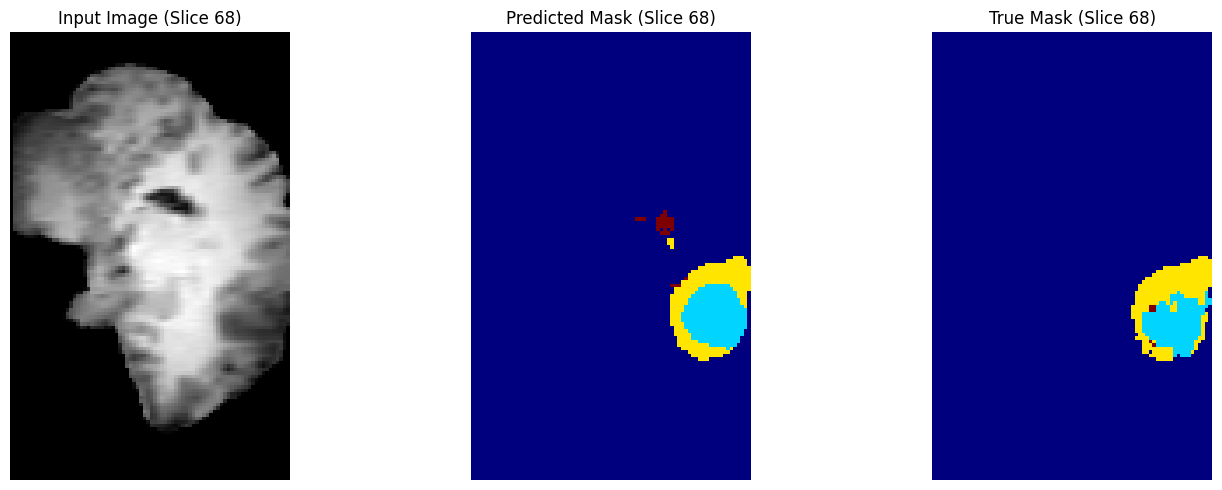

In [28]:
val_batch = next(iter(validation_dataloader))
inputs = val_batch[0].to(device)  
labels = val_batch[1].to(device)     


with torch.no_grad():
    outputs = model(inputs)  
    preds = torch.argmax(outputs, dim=1)  


img = inputs[0]  
if labels.ndim == 5:
    true_mask = labels[0, 0]  
else:
    true_mask = labels[0]     
pred_mask = preds[0]          


img_vol = img[0].cpu().numpy()
true_mask_vol = true_mask.cpu().numpy()
pred_mask_vol = pred_mask.cpu().numpy()


def show_slice(slice_index: int):
   
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    
    axes[0].imshow(img_vol[slice_index], cmap="gray")
    axes[0].set_title(f"Input Image (Slice {slice_index})")
    axes[0].axis("off")
    
   
    axes[1].imshow(pred_mask_vol[slice_index], cmap="jet")
    axes[1].set_title(f"Predicted Mask (Slice {slice_index})")
    axes[1].axis("off")
    
    
    axes[2].imshow(true_mask_vol[slice_index], cmap="jet")
    axes[2].set_title(f"True Mask (Slice {slice_index})")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()
show_slice(68)


another plot from 7th batch of the validation dataloader alonf with predicted mask and the true mask

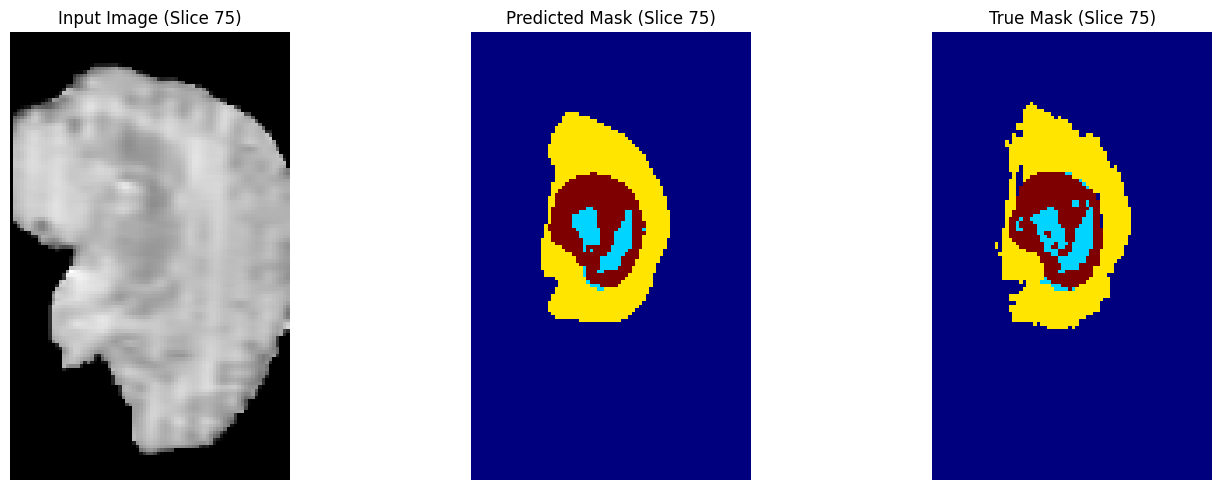

In [39]:
val_batch = next(itertools.islice(iter(validation_dataloader), 6, None))
inputs = val_batch[0].to(device)  
labels = val_batch[1].to(device)     

with torch.no_grad():
    outputs = model(inputs)  
    preds = torch.argmax(outputs, dim=1)  

img = inputs[0]  
if labels.ndim == 5:
    true_mask = labels[0, 0]  
else:
    true_mask = labels[0]     
pred_mask = preds[0]          

img_vol = img[0].cpu().numpy()
true_mask_vol = true_mask.cpu().numpy()
pred_mask_vol = pred_mask.cpu().numpy()

def show_slice(slice_index: int):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_vol[slice_index], cmap="gray")
    axes[0].set_title(f"Input Image (Slice {slice_index})")
    axes[0].axis("off")
    
    axes[1].imshow(pred_mask_vol[slice_index], cmap="jet")
    axes[1].set_title(f"Predicted Mask (Slice {slice_index})")
    axes[1].axis("off")
    
    axes[2].imshow(true_mask_vol[slice_index], cmap="jet")
    axes[2].set_title(f"True Mask (Slice {slice_index})")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()

show_slice(75)


In [31]:
'''finally, I wanted to plot all three photos in a 3D way so
I could see better how accurate my model was in its predictions'''
for batch, (data, targets) in enumerate(validation_dataloader):
    if batch == 9:
        data = data.to(device)
        targets = targets.to(device)
        break


model.eval()
with torch.no_grad():
    predictions = model(data)


image = data[0, 0, :, :, :].cpu().numpy()  
true_mask = targets[0, :, :, :].cpu().numpy()
if true_mask.shape[0] == 1:
    true_mask = true_mask.squeeze(0)
predicted_mask = torch.argmax(predictions, dim=1)[0, :, :, :].cpu().numpy()


def create_3d_plot(slice_idx):
    fig = go.Figure()


    fig.add_trace(go.Surface(
        z=slice_idx * np.ones_like(image[slice_idx]),
        surfacecolor=image[slice_idx],
        colorscale="gray",
        name="Original"
    ))

  
    fig.add_trace(go.Surface(
        z=(slice_idx + 5) * np.ones_like(true_mask[slice_idx]),
        surfacecolor=true_mask[slice_idx],
        colorscale="jet",
        opacity=0.7,
        name="True Mask"
    ))


    fig.add_trace(go.Surface(
        z=(slice_idx + 10) * np.ones_like(predicted_mask[slice_idx]),
        surfacecolor=predicted_mask[slice_idx],
        colorscale="jet",
        opacity=0.7,
        name="Predicted Mask"
    ))

    fig.update_layout(
        title="3D Visualization of Image & Masks",
        scene=dict(
            zaxis=dict(title="Slices"),
            xaxis=dict(title="X"),
            yaxis=dict(title="Y")
        ),
        margin=dict(l=0, r=0, b=0, t=40)  
    )

    fig.show()


def interactive_plot():
    interact(create_3d_plot, slice_idx=IntSlider(min=0, max=image.shape[0] - 1, step=1, value=image.shape[0] // 2))


interactive_plot()


interactive(children=(IntSlider(value=56, description='slice_idx', max=111), Output()), _dom_classes=('widget-…

here, I wanted to show the real mask as well as model's prediction on MRI image side by side. This function uses gets the batch number of the validation dataloader, gives it to the model and gets its prediction. Then, the real mask and the model's prediction get overlayed on the image. My main purpose was to give a scrolling sense, just like when a radiologist looks at an MRI study.

In [49]:
def visualize_3d_segmentation(batch_num, output_gif_pred="segmentation_pred.gif", output_gif_real="segmentation_real.gif"):
    for batch, (data, targets) in enumerate(validation_dataloader):
        if batch == batch_num:
            data = data.to(device)
            targets = targets.to(device)
            break

    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        predictions = model(data)
    
    
    image = data[0, 0, :, :, :].cpu().numpy()  
    true_mask = targets[0, :, :, :].cpu().numpy()
    
    if true_mask.shape[0] == 1:
        true_mask = true_mask.squeeze(0)
    
    predicted_mask = torch.argmax(predictions, dim=1)[0, :, :, :].cpu().numpy()
    predicted_mask_tensor = torch.tensor(predicted_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    resized_predicted_mask = F.interpolate(predicted_mask_tensor, size=(240, 240, 155), mode='trilinear', align_corners=False)
    resized_predicted_mask = resized_predicted_mask.squeeze(0).squeeze(0).round().cpu().numpy().astype(int)
    
    channel_index = 3 
    selected_channel = data[0, channel_index, :, :, :].unsqueeze(0).unsqueeze(0)
    resized_channel = F.interpolate(selected_channel, size=(240, 240, 155), mode='trilinear', align_corners=False)
    resized_channel = resized_channel.squeeze(0).squeeze(0).cpu()

    targets_tensor = torch.tensor(true_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    resized_targets_tensor = F.interpolate(targets_tensor, size=(240, 240, 155), mode='trilinear', align_corners=False)
    resized_targets_tensor = resized_targets_tensor.squeeze(0).squeeze(0).round().cpu().numpy().astype(int)

    
    print(resized_channel.shape)
    print(resized_predicted_mask.shape)
    print(data.shape)


    
    mri_study = resized_channel  
    seg = resized_predicted_mask
    real_seg = resized_targets_tensor

    num_slices = mri_study.shape[-1]
    images_pred = []
    images_real = []

    for i in range(num_slices):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        
        axes[0].imshow(mri_study[:, :, i], cmap='gray')
        predicted_mask_overlay = np.ma.masked_where(seg[:, :, i] == 0, seg[:, :, i])
        axes[0].imshow(predicted_mask_overlay, cmap='jet', alpha=0.5)
        axes[0].set_title('Predicted Segmentation')
        axes[0].axis('off')

        
        axes[1].imshow(mri_study[:, :, i], cmap='gray')
        real_mask_overlay = np.ma.masked_where(real_seg[:, :, i] == 0, real_seg[:, :, i])
        axes[1].imshow(real_mask_overlay, cmap='jet', alpha=0.5)
        axes[1].set_title('Ground Truth Segmentation')
        axes[1].axis('off')
        
        plt.tight_layout()
        
       
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images_pred.append(image)
        
        
        fig.canvas.draw()
        image_real = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_real = image_real.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images_real.append(image_real)
        
        plt.close(fig)

    
    imageio.mimsave(output_gif_pred, images_pred, duration=0.2)
    imageio.mimsave(output_gif_real, images_real, duration=0.2)
    print(f"GIF saved as {output_gif_pred} and {output_gif_real}")



visualize_3d_segmentation(7)

torch.Size([240, 240, 155])
(240, 240, 155)
torch.Size([8, 4, 112, 128, 80])
GIF saved as segmentation_pred.gif and segmentation_real.gif


In [50]:
FileLink(r'./segmentation_pred.gif')
#FileLink(r'./segmentation_real.gif')

/kaggle/working/segmentation_pred.gif